import everything

In [133]:
import os
import cv2
import math
import scipy
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
from skimage import measure
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.transform import resize
from skimage.util import img_as_float
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_score
from skimage.measure import label, regionprops
from openniftiimages import load_and_display_nifti
from scipy.spatial.distance import directed_hausdorff
from skimage.segmentation import find_boundaries, mark_boundaries

read the file to get patient ID and the slices used

In [134]:
patient_info_file = r'G:\Annekoos Schaap - code\Data\All_imaging_features_NKI.xlsx'
base_nifti_path = r'G:\NKI dataset\Data_nifti'

# Read the patient info
patient_info_df = pd.read_excel(patient_info_file)

read the mask area coordinates

In [135]:
# read Excel
filename = 'coordinates_429.xlsx'
df = pd.read_excel(filename, sheet_name='Sheet1', header=None)
filename_1 = 'coordinates_1.xlsx'
df_1 = pd.read_excel(filename_1, sheet_name='Sheet1', header=None)
print(df)

print(len(df))
print(len(patient_info_df))

      0    1    2    3      4
0   193  199  370  298  13260
1   137  139  342  276  22008
2   177  197  352  292  12968
3   153  245  352  360  18060
4   175  195  340  316  15068
5   173  205  332  308  13044
6   183  171  324  270  11812
7   161  187  346  318  19204
8   183  201  348  306  13980
9   175  205  348  312  13996
10  177  199  346  334  16816
11  141  209  360  340  22948
12  177  225  366  338  14876
13  143  159  362  330  29352
14  169  189  338  302  14960
15  193  231  346  336  12676
16  159  203  338  310  13868
17  157  215  350  318  16856
18  189  231  336  312  10588
19  175  267  342  384  15516
20  195  233  346  352  14444
21  187  227  342  306   9776
22  183  221  344  320  12516
23  161  171  384  304  23276
24  183  245  346  326   9900
25  173  221  352  342  18156
26   81   92  164  146   3495
27  188   89  387  263  27807
28  203  183  373  331  19795
29  303  295  410  371   5618
30  298  276  415  355   6973
31  284  312  415  412  10643
32  268  2

In [136]:
dice_score_all = []
dice_score_from_jaccard_all = []
hausdorff_dist_all = []
asd_all = []
alpha_all = []
prostate_mask_all = []
predicted_mask_all = []
SLICresult = []
pixel_labels = []

In [137]:
metrics_data = {
    'patient_name': [],
    'alpha': [],
    'dice_score': [],
    'hausdorff_dist': [],
    'asd': [],
    'n_segment': []
}

from the table given, go through the columns of patient name and slice.
combine the path of T2.nii for each patient --> 'nifti_path'
load the .nii file and reach for the data
make the slice rotated to the right angel and rescale the image --> 'rescaled_image'
corrupt the image based on the coordinates --> 'region'
apply SLIC within the corrupted image: 'segments' are the labels of all superpixels from 1; 'boundaries_1' is a boolen matrix marking boundaries and other areas; 'image_with_boundaries_1' is a RGB image overlapping the image and the boundaries
read the prostate mask from the path --> 'mat_file_path'
keep the mask as boolen and corrupt the mask according to the coordinates
find the boundaries of the prostate mask --> 'prostate_boundaries'


In [138]:
# Define the threshold
threshold = 0.75

In [139]:
def extract_boundary_points(mask):
    if mask.ndim != 2 or mask.size == 0:
        print("掩模形状无效:", mask.shape)
        return np.array([])  # 如果掩模不是二维或为空，则返回一个空数组

    contours = measure.find_contours(mask, level=0.5)
    points = []
    for contour in contours:
        for point in contour:
            points.append(point)
    return np.array(points)

In [140]:
def calculate_metrics(predicted_mask, prostate_mask):

    # Dice score 
    dice_score = 2 * np.sum(predicted_mask & prostate_mask) / (np.sum(predicted_mask) + np.sum(prostate_mask))

    # Jaccard index Dice score: 2 * Jaccard index / (1 + Jaccard index)
    jaccard_index = jaccard_score(prostate_mask.flatten(), predicted_mask.flatten())
    dice_score_from_jaccard = 2 * jaccard_index / (1 + jaccard_index)

    # Hausdorff distance
    u = np.transpose(np.nonzero(prostate_mask))
    v = np.transpose(np.nonzero(predicted_mask))
    hausdorff_dist = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

    print(prostate_mask.shape)
    print(predicted_mask.shape)

    return dice_score, dice_score_from_jaccard, hausdorff_dist

In [141]:
def calculate_asd(mask1, mask2):
    # 提取两个掩模的边界点
    points1 = extract_boundary_points(mask1)
    points2 = extract_boundary_points(mask2)

    print(points1.shape)
    print(points2.shape)

    # 如果任一点集为空，返回NaN
    if points1.size == 0 or points2.size == 0:
        return np.nan
    
    # 计算点集之间的距离
    distances_1_to_2 = cdist(points1, points2, metric='euclidean')
    distances_2_to_1 = cdist(points2, points1, metric='euclidean')
    
    # 找到最短距离并计算平均值
    min_distances_1_to_2 = np.min(distances_1_to_2, axis=1)
    min_distances_2_to_1 = np.min(distances_2_to_1, axis=1)
    
    # 计算两个方向的平均表面距离
    asd_1_to_2 = np.mean(min_distances_1_to_2)
    asd_2_to_1 = np.mean(min_distances_2_to_1)
    
    # 返回双向平均表面距离
    return (asd_1_to_2 + asd_2_to_1) / 2

In [142]:
for index, row in patient_info_df.iterrows():
    for alpha in np.arange(5, 7, 0.1):
        patient_name = row['Patient name ']
        slice_no = int(np.floor(row['Slice no. ']))  # Assuming 'Slice no.' column contains integers
        print(f"Processing {patient_name}, Slice {slice_no}...")
        # Construct the path to the NIfTI file
        nifti_path = os.path.join(base_nifti_path, patient_name, 'NIFTIs', 'T2.nii')
        
        # Load the NIfTI image
        nifti_image = nib.load(nifti_path)
        data_nifti = nifti_image.get_fdata()
        
        # Check if the number of dimensions is correct
        if data_nifti.ndim == 3:
            # Get the specific slice
            image_slice = data_nifti[:, :, slice_no - 1]
            
            # Process the image slice
            image_nifti = np.rot90(image_slice, 3)
            image_nifti = np.fliplr(image_nifti)
            minni = np.min(image_nifti)
            maxni = np.max(image_nifti)
            rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
            rescaled_image = rescaled_image.astype(np.uint8)

            # Get coordinates for the current patient
            # Assuming each patient has a corresponding row in the coordinates Excel file
            
            minX, minY, maxX, maxY = df.iloc[index, :4]

            y_min = minY - 25
            # y_max = min(maxY + 10, rescaled_image.shape[0])
            y_max = maxY + 10
            x_min = minX - 20
            # x_max = min(maxX + 20, rescaled_image.shape[1])
            x_max = maxX + 20
            area = rescaled_image[y_min:y_max, x_min:x_max]
            print(area.shape)

            mat_file_path = os.path.join(r'C:\Users\alexg\Desktop\study\graduation project\code\prostate_ROI_429', f'{patient_name}_{slice_no}_prostate_ROI.png')
            image = cv2.imread(mat_file_path, cv2.IMREAD_GRAYSCALE)
            prostate_mask = image.astype(bool)
            # mat_file_path = os.path.join(base_nifti_path, 'logic_adjusted_masks', f'adjusted_patient_{patient_name}', f'adjusted_prostate_slice_{patient_name}', f'adjusted_prostate_slice_{slice_no}.mat')
            # mat = scipy.io.loadmat(mat_file_path)
            # prostate_mask = mat['logic_image']


            prostate_mask = prostate_mask[y_min:y_max, x_min:x_max]

            if prostate_mask.shape != area.shape:
                prostate_mask = resize(prostate_mask, area.shape, order=0, preserve_range=True, anti_aliasing=False).astype(bool)

            print(prostate_mask.shape)

            pixel_amount = np.sum(prostate_mask)
            print(pixel_amount)
            n_segment = round(pixel_amount * math.exp(-alpha))
                
            segments = slic(area, n_segments=n_segment, compactness=0.05, sigma=1, start_label=1, channel_axis=None)
            boundaries_1 = find_boundaries(segments, mode='inner')
            image_with_boundaries_1 = mark_boundaries(area, boundaries_1, color=(1, 0, 0))
            print(segments.shape)
            # alpha = -math.log(n_segment/pixel_amount)

            predicted_mask = np.zeros_like(prostate_mask)
            print(area.dtype, area.shape)
            
            for region in regionprops(label(segments)):
                # Extract the superpixel region
                superpixel = (segments == region.label)
                
                # Calculate overlap with the prostate mask
                overlap = np.sum(superpixel & prostate_mask) / np.sum(superpixel)
                
                # If overlap exceeds the threshold, consider it as part of the prostate
                if overlap > threshold:
                    predicted_mask[superpixel] = 1


            dice_score, dice_score_from_jaccard, hausdorff_dist = calculate_metrics(predicted_mask, prostate_mask)
            asd = calculate_asd(predicted_mask, prostate_mask)

        prostate_mask_all.append(prostate_mask)
        predicted_mask_all.append(predicted_mask)
        SLICresult.append(image_with_boundaries_1)
        pixel_labels.append(segments)

        metrics_data['patient_name'].append(patient_name)
        metrics_data['alpha'].append(alpha)
        metrics_data['dice_score'].append(dice_score)
        metrics_data['hausdorff_dist'].append(hausdorff_dist)
        metrics_data['asd'].append(asd)
        metrics_data['n_segment'].append(n_segment)

        print(f"Finished processing {patient_name}, Slice {slice_no}.\n")

    
print("All patients processed. Calculating metrics...")



Processing MRI002, Slice 10...
(134, 217)
(134, 217)
13260
(134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(961, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
(134, 217)
13260
(134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(937, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
(134, 217)
13260
(134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(869, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
(134, 217)
13260
(134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(909, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
(134, 217)
13260
(134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(1107, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Processing MRI002, Slice 10...
(134, 217)
(134, 217)
13260
(134, 217)
uint8 (134, 217)
(134, 217)
(134, 217)
(893, 2)
(581, 2)
Finished processing MRI002, Slice 10.

Pro

try first patient's 15th superpixel

In [21]:
# # 标注第一个患者的第15个superpixel
# first_patient_index = 10
# first_segments = pixel_labels[203]
# target_superpixel_label = 63

# # 创建一个二值掩码，仅包含目标superpixel
# superpixel_mask = (first_segments == target_superpixel_label)

# # 标注图像中的目标superpixel
# image_with_target_superpixel = mark_boundaries(SLICresult[203], superpixel_mask, color=(0, 1, 0))

# # 显示和保存标注后的图像
# plt.figure(figsize=(10, 10))
# plt.imshow(image_with_target_superpixel, cmap='gray')
# plt.axis('off')

# save_folder = r'D:\maskc506'
# os.makedirs(save_folder, exist_ok=True)
# save_path = os.path.join(save_folder, 'patient_63_target_superpixel.png')

# plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
# plt.close()

# print("All patients processed. Calculating metrics...")

All patients processed. Calculating metrics...


In [13]:
evaluation_save = pd.DataFrame(metrics_data)
evaluation_save[evaluation_save['patient_name'].str.contains('002')]

patient_name  alpha  dice_score  hausdorff_dist        asd  n_segment
0        MRI002    5.0    0.872879       14.866069   5.256123         89
1        MRI002    5.1    0.834606       23.706539   7.446590         81
2        MRI002    5.2    0.890872       12.165525   4.821134         73
3        MRI002    5.3    0.862063       13.416408   6.247926         66
4        MRI002    5.4    0.876653       13.601471   5.143888         60
5        MRI002    5.5    0.851869       16.031220   6.799238         54
6        MRI002    5.6    0.829059       19.924859   8.143765         49
7        MRI002    5.7    0.820941       19.313208   8.160758         44
8        MRI002    5.8    0.804980       16.278821   8.409735         40
9        MRI002    5.9    0.818118       16.155494   7.850209         36
10       MRI002    6.0    0.731019       24.413111  10.898544         33
11       MRI002    6.1    0.725283       28.017851  11.123543         30
12       MRI002    6.2    0.829166       17.262677   7.125074         27
13       MRI002    6.3    0.766074       46.270941   9.213679         24
14       MRI002    6.4    0.735773       42.190046  11.105537         22
15       MRI002    6.5    0.813307       15.811388   7.634987         20
16       MRI002    6.6    0.706897       48.010416  12.021725         18
17       MRI002    6.7    0.649512       48.041649  12.344339         16
18       MRI002    6.8    0.740550       18.027756   9.982540         15
19       MRI002    6.9    0.822952       18.439089   7.711929         13

In [14]:
# 使用pandas创建DataFrame
evaluation_save = pd.DataFrame(metrics_data)

with pd.ExcelWriter('table13.xlsx') as writer:
    evaluation_save.pivot_table(index=['patient_name', 'alpha'], values='dice_score').unstack().to_excel(writer, sheet_name='Dice Scores')
    evaluation_save.pivot_table(index=['patient_name', 'alpha'], values='hausdorff_dist').unstack().to_excel(writer, sheet_name='Hausdorff Distances')
    evaluation_save.pivot_table(index=['patient_name', 'alpha'], values='asd').unstack().to_excel(writer, sheet_name='ASD')
    # evaluation_save.pivot_table(index=['patient_name', 'alpha'], values='alpha').unstack().to_excel(writer, sheet_name='Alpha')
    evaluation_save.pivot_table(index=['patient_name', 'alpha'], values='n_segment').unstack().to_excel(writer, sheet_name='n_segment')

print('Data saved to Excel file successfully.')

Data saved to Excel file successfully.


In [143]:
path_e = r'C:\Users\alexg\Desktop\study\graduation project\code\table13.xlsx'

df_0 = pd.read_excel(path_e, sheet_name='Dice Scores', header=None)
df_1 = pd.read_excel(path_e, sheet_name='Dice Scores', header=None).drop(columns=[0])
df_2 = pd.read_excel(path_e, sheet_name='Hausdorff Distances', header=None).drop(columns=[0])
df_3 = pd.read_excel(path_e, sheet_name='ASD', header=None).drop(columns=[0])
# df_4 = pd.read_excel(path_e, sheet_name='Alpha', header=None).drop(columns=[0])
df_5 = pd.read_excel(path_e, sheet_name='n_segment', header=None).drop(columns=[0])

df_D = (df_1 - df_1.min()) / (df_1.max() - df_1.min())
df_H = 1 - ((df_2 - df_2.min()) / (df_2.max() - df_2.min()))
df_A = 1 - (df_3 - df_3.min()) / (df_3.max() - df_3.min())

ideal_best = np.ones((35,20))
ideal_worst = np.zeros((35,20))

Distance_to_Best = np.sqrt((df_D - ideal_best) ** 2 + (df_H - ideal_best) ** 2 + (df_A - ideal_best) ** 2)
Distance_to_worst = np.sqrt((df_D - ideal_worst) ** 2 + (df_H - ideal_worst) ** 2 + (df_A - ideal_worst) ** 2)

closeness= Distance_to_worst / (Distance_to_Best + Distance_to_worst)

In [144]:
df_ids = df_0.iloc[:, 0]

best_alphas_topsis = np.max(closeness, axis=1)
best_alphas_index = np.argmax(closeness, axis=1)

print(best_alphas_topsis)
print(best_alphas_index)

0     0.939447
1     0.927487
2     0.876595
3     1.000000
4     0.905330
5     0.853618
6     0.888116
7     0.888499
8     0.884008
9     0.950216
10    0.979936
11    0.990245
12    0.997961
13    0.965986
14    0.931437
15    0.921144
16    0.986116
17    0.916484
18    0.790683
19    0.975669
20    0.972620
21    0.990872
22    0.972778
23    0.912773
24    0.783025
25    0.969405
26    0.868822
27    0.964764
28    1.000000
29    0.867124
30    0.964313
31    1.000000
32    0.929683
33    0.772550
34    0.708878
dtype: float64
[19 11 18  2 18 12 14 18 12 18 18  6 13 12 11 15 19  9 19 16 18 19 15 16
 18 14 13  7  8 10 13 14 12  5 11]


In [145]:
df_ids = df_0.iloc[:, 0]

best_alphas_topsis = np.max(closeness, axis=1)
best_alphas_index = np.argmax(closeness, axis=1)

for df_id,(value, index) in zip(df_ids, zip(best_alphas_topsis,best_alphas_index)):
    print(f"patient {df_id}: achieves the best segmentation when alpha is {(index * 0.1 + 5.0):.4f} and n_segment is {round(pixel_amount * math.exp(-(index * 0.1 + 5.0)))} ")

patient MRI002: achieves the best segmentation when alpha is 6.9000 and n_segment is 5 
patient MRI006: achieves the best segmentation when alpha is 6.1000 and n_segment is 11 
patient MRI008: achieves the best segmentation when alpha is 6.8000 and n_segment is 5 
patient MRI009: achieves the best segmentation when alpha is 5.2000 and n_segment is 27 
patient MRI012: achieves the best segmentation when alpha is 6.8000 and n_segment is 5 
patient MRI014: achieves the best segmentation when alpha is 6.2000 and n_segment is 10 
patient MRI016: achieves the best segmentation when alpha is 6.4000 and n_segment is 8 
patient MRI018: achieves the best segmentation when alpha is 6.8000 and n_segment is 5 
patient MRI019: achieves the best segmentation when alpha is 6.2000 and n_segment is 10 
patient MRI020: achieves the best segmentation when alpha is 6.8000 and n_segment is 5 
patient MRI021: achieves the best segmentation when alpha is 6.8000 and n_segment is 5 
patient MRI022: achieves the

In [19]:
results_df = pd.DataFrame({
    'Patient ID': df_ids,
    'Best Alpha Value': best_alphas_index * 0.1 + 5.0,
    'Best n_segment Value': np.round(pixel_amount * np.exp(-(best_alphas_index * 0.1 + 5.0))).astype(int)
})

# 指定Excel文件路径
excel_path = r'C:/Users/alexg/Desktop/study/graduation project/code/results726.xlsx'

# 将DataFrame写入到Excel文件
results_df.to_excel(excel_path, index=False)  # 设置index=False来避免添加未命名的索引列到文件

print('Data saved to Excel successfully.')

Data saved to Excel successfully.


In [146]:
import scipy.io

# 读取 .mat 文件
mat_data = scipy.io.loadmat('tumor_coordinates.mat')

# 提取 'coordinates_all' 变量
coordinates_all = mat_data['coordinates_all']

# # 打印数据以验证
# print(coordinates_all)


In [160]:
# for i in range(coordinates_all.shape[0]):
#     for j in range(coordinates_all.shape[1]):
#         if coordinates_all[i, j].size > 0:  # 检查是否有坐标数据
#             coordinates = coordinates_all[i, j][0]
#             if coordinates.ndim == 2 and coordinates.shape[1] == 2:
#                 coordinates_all[i, j][0] = coordinates[:, [1, 0]]  # 交换 x 和 y 轴


In [147]:
print(coordinates_all[1,:])

[array([[ 81,  47],
        [ 77,  48],
        [ 78,  48],
        ...,
        [ 60, 210],
        [ 62, 214],
        [ 63, 215]], dtype=uint8)]


In [26]:
A = coordinates_all[1,:]
B = A[0]
print(B[0])
print(B[1])
print(B[2])

[81 47]
[77 48]
[78 48]


In [163]:
excel_path = r'C:/Users/alexg/Desktop/study/graduation project/code/results726.xlsx'
column = pd.read_excel(excel_path)

NEW = []

for index, row in column.iterrows():
    patient_id = row['Patient ID']
    alpha = row['Best Alpha Value']
    image_index = int((alpha-5.0)/0.1)
    for prostate_mask, predicted_mask, image_with_boundaries_1 in zip(prostate_mask_all, predicted_mask_all, SLICresult):
        prostate_boundaries = find_boundaries(prostate_mask_all[20 * index + image_index], mode='inner')
        prediction_boundaries = find_boundaries(predicted_mask_all[20 * index + image_index], mode='inner')

        image_with_boundaries_2 = mark_boundaries(SLICresult[20 * index + image_index], prostate_boundaries, color=(0, 0, 1))
        image_with_boundaries_3 = mark_boundaries(image_with_boundaries_2, prediction_boundaries, color=(0, 1, 0))

        tumor_coordinates = coordinates_all[index]
        tumor_coordinates = tumor_coordinates[0]

        # tumor_coordinates = np.array([[y, x] for x, y in tumor_coordinates])
        # print(tumor_coordinates)
        # tumor_coordinates = np.fliplr(tumor_coordinates)
        # tumor_coordinates = np.rot90(tumor_coordinates)

        # # print(f'tumor_coordinates shape: {tumor_coordinates.shape}')
        # # print(tumor_coordinates)

        #     # 显示灰度图并标记区域
        # plt.imshow(image_with_boundaries_3, cmap='gray')

        # # 将 tumor_coordinates 中所有坐标围成的区域标记出来
        # tumor_polygon = plt.Polygon(tumor_coordinates, closed=True, edgecolor='r', linewidth=2, fill=None)
        # plt.gca().add_patch(tumor_polygon)

        # plt.axis('equal')
        # plt.show()

        # 获取边界
        min_row, min_col = np.min(tumor_coordinates, axis=0)
        max_row, max_col = np.max(tumor_coordinates, axis=0)

        # 创建矩阵
        matrix = np.zeros((max_row - min_row + 1, max_col - min_col + 1), dtype=int)

        # 将坐标映射到矩阵
        for coord in tumor_coordinates:
            row, col = coord
            matrix[row - min_row, col - min_col] = 1

        # # 左右翻转
        # matrix_flipped = np.fliplr(matrix)

        # # 逆时针旋转90度
        # matrix_rotated = np.rot90(matrix_flipped)

        # 提取新的坐标
        new_coordinates = np.argwhere(matrix == 1)
        # new_coordinates = new_coordinates[:, [1, 0]]  # 列与行交换
        new_coordinates += [min_col, min_row]  # 加上偏移量
    NEW.append(new_coordinates)

        # print("原始坐标：")
        # print(tumor_coordinates)
        # print("翻转并旋转后的坐标：")
        # print(new_coordinates)

        # # 显示灰度图并标记区域
        # plt.imshow(image_with_boundaries_3, cmap='gray')

        # # 将 tumor_coordinates 中所有坐标围成的区域标记出来
        # tumor_polygon = plt.Polygon(new_coordinates, closed=True, edgecolor='r', linewidth=2, fill=None)
        # plt.gca().add_patch(tumor_polygon)

        # plt.axis('equal')
        # plt.show()

# NEW = np.array([new_coordinates[np.newaxis, :] for new_coordinates in NEW], dtype=object)







        # # 设置图像和标记肿瘤区域
        # plt.figure(figsize=(10, 10))
        # plt.imshow(image_with_boundaries_3, cmap='gray')
        # plt.scatter(tumor_coordinates[:, 1], tumor_coordinates[:, 0], c='red', s=1) 
        # plt.axis('off')

        # # 保存图像
        # save_folder = r'D:\maskc506'
        # os.makedirs(save_folder, exist_ok=True)
        # save_path_1 = os.path.join(save_folder, f'patient_{patient_id}_comparison_{image_index}.png')

        # plt.savefig(save_path_1, bbox_inches='tight', pad_inches=0)
        # plt.close()

        # plt.figure(figsize=(10, 10))
        # plt.imshow(image_with_boundaries_3, cmap='gray')
        # plt.axis('off')

        # save_folder = r'D:\maskc506'
        # os.makedirs(save_folder, exist_ok=True)
        # save_path = os.path.join(save_folder, f'patient_{patient_id}_comparison_{alpha}.png')

        # plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
        # plt.close()
        # save_path
        # del prostate_mask, predicted_mask, image_with_boundaries_1


In [164]:
print(NEW[:])

[array([[ 90,  22],
       [ 91,  22],
       [ 92,  22],
       ...,
       [108, 141],
       [106, 142],
       [107, 142]], dtype=int64), array([[ 81,  47],
       [ 77,  48],
       [ 78,  48],
       ...,
       [ 60, 210],
       [ 62, 214],
       [ 63, 215]], dtype=int64), array([[ 54,  74],
       [ 55,  74],
       [ 56,  74],
       ...,
       [ 41, 140],
       [ 42, 140],
       [ 42, 141]], dtype=int64), array([[110,  45],
       [111,  45],
       [112,  45],
       ...,
       [122,  91],
       [123,  91],
       [124,  91]], dtype=int64), array([[ 85,  38],
       [ 86,  38],
       [ 87,  38],
       ...,
       [121, 185],
       [122, 185],
       [123, 185]], dtype=int64), array([[ 44,  67],
       [ 45,  67],
       [ 46,  67],
       ...,
       [115, 150],
       [116, 150],
       [117, 150]], dtype=int64), array([[ 47, 128],
       [ 48, 128],
       [ 49, 128],
       ...,
       [ 83, 172],
       [ 84, 172],
       [ 85, 172]], dtype=int64), array([[ 87,

In [165]:
print(len(NEW))

35


In [179]:
print(NEW[0].shape)

(4644, 2)


In [167]:
print(NEW[0].shape)

(4644, 2)


In [168]:
print(coordinates_all[0][0].shape)

(4644, 2)


In [18]:
# # MRI024 MRI044
# excel_path = r'C:/Users/alexg/Desktop/study/graduation project/code/results5_6.xlsx'
# column = pd.read_excel(excel_path)

# patient_id_1 = 'MRI024'
# image_index_1 = 8
# patient_id_2 = 'MRI044'
# image_index_2 = 7

# prostate_boundaries_1 = find_boundaries(prostate_mask_all[20 * 13 + image_index_1], mode='inner')
# prediction_boundaries_1 = find_boundaries(predicted_mask_all[20 * 13 + image_index_1], mode='inner')
# image_with_boundaries_2_1 = mark_boundaries(SLICresult[20 * 13 + image_index_1], prostate_boundaries_1, color=(0, 0, 1))
# image_with_boundaries_3_1 = mark_boundaries(image_with_boundaries_2_1, prediction_boundaries_1, color=(0, 1, 0))

# prostate_boundaries_2 = find_boundaries(prostate_mask_all[20 * 27 + image_index_2], mode='inner')
# prediction_boundaries_2 = find_boundaries(predicted_mask_all[20 * 27 + image_index_2], mode='inner')
# image_with_boundaries_2_2 = mark_boundaries(SLICresult[20 * 27 + image_index_2], prostate_boundaries_2, color=(0, 0, 1))
# image_with_boundaries_3_2 = mark_boundaries(image_with_boundaries_2_2, prediction_boundaries_2, color=(0, 1, 0))

# # 设置第一个图像
# plt.figure(figsize=(10, 10))
# plt.imshow(image_with_boundaries_3_1, cmap='gray')
# plt.axis('off')

# save_folder = r'D:\maskc506'
# os.makedirs(save_folder, exist_ok=True)
# save_path_1 = os.path.join(save_folder, f'patient_{patient_id_1}_comparison_{image_index_1}.png')

# plt.savefig(save_path_1, bbox_inches='tight', pad_inches=0)
# plt.close()

# # 设置第二个图像
# plt.figure(figsize=(10, 10))
# plt.imshow(image_with_boundaries_3_2, cmap='gray')
# plt.axis('off')

# save_path_2 = os.path.join(save_folder, f'patient_{patient_id_2}_comparison_{image_index_2}.png')

# plt.savefig(save_path_2, bbox_inches='tight', pad_inches=0)
# plt.close()

#########################################################################################

# for index, row in column.iterrows():
#     patient_id = 'MRI024'
#     alpha = '5.8'
#     image_index = int((alpha-5.0)/0.1)
#     for prostate_mask, predicted_mask, image_with_boundaries_1 in zip(prostate_mask_all, predicted_mask_all, SLICresult):
#         prostate_boundaries = find_boundaries(prostate_mask_all[20 * index + image_index], mode='inner')
#         prediction_boundaries = find_boundaries(predicted_mask_all[20 * index + image_index], mode='inner')

#         image_with_boundaries_2 = mark_boundaries(SLICresult[20 * index + image_index], prostate_boundaries, color=(0, 0, 1))
#         image_with_boundaries_3 = mark_boundaries(image_with_boundaries_2, prediction_boundaries, color=(0, 1, 0))

#         plt.figure(figsize=(10, 10))
#         plt.imshow(image_with_boundaries_3, cmap='gray')
#         plt.axis('off')

#         save_folder = r'D:\maskc506'
#         os.makedirs(save_folder, exist_ok=True)
#         save_path = os.path.join(save_folder, f'patient_{patient_id}_comparison_{alpha}.png')

#         plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
#         plt.close()
#         save_path
#         del prostate_mask, predicted_mask, image_with_boundaries_1


In [28]:
patient_id = 'MRI021'
image_index = 3

prostate_boundaries = find_boundaries(prostate_mask_all[200 + image_index], mode='inner')
prediction_boundaries = find_boundaries(predicted_mask_all[200 + image_index], mode='inner')
image_with_boundaries_2 = mark_boundaries(SLICresult[200 + image_index], prostate_boundaries, color=(0, 0, 1))
image_with_boundaries_3 = mark_boundaries(image_with_boundaries_2, prediction_boundaries, color=(0, 1, 0))



# 设置第一个图像
plt.figure(figsize=(10, 10))
plt.imshow(image_with_boundaries_3, cmap='gray')
plt.axis('off')

save_folder = r'D:\maskc506'
os.makedirs(save_folder, exist_ok=True)
save_path_1 = os.path.join(save_folder, f'patient_{patient_id}_comparison_{image_index}.png')

plt.savefig(save_path_1, bbox_inches='tight', pad_inches=0)
plt.close()



In [127]:
# excel_path = r'C:/Users/alexg/Desktop/study/graduation project/code/results726.xlsx'
# column = pd.read_excel(excel_path)

# # 选取第一行数据
# first_row = column.iloc[0]
# patient_id = first_row['Patient ID']
# alpha = first_row['Best Alpha Value']
# image_index = int((alpha - 5.0) / 0.1)

# # 处理第一行数据
# for prostate_mask, predicted_mask, image_with_boundaries_1 in zip(prostate_mask_all, predicted_mask_all, SLICresult):
#     prostate_boundaries = find_boundaries(prostate_mask_all[20 * 0 + image_index], mode='inner')
#     prediction_boundaries = find_boundaries(predicted_mask_all[20 * 0 + image_index], mode='inner')

#     image_with_boundaries_2 = mark_boundaries(SLICresult[20 * 0 + image_index], prostate_boundaries, color=(0, 0, 1))
#     image_with_boundaries = mark_boundaries(image_with_boundaries_2, prediction_boundaries, color=(0, 1, 0))

# for index, row in column.iterrows():
#     patient_id = row['Patient ID']
#     alpha = row['Best Alpha Value']
#     image_index = int((alpha-5.0)/0.1)
#     for prostate_mask, predicted_mask, image_with_boundaries_1 in zip(prostate_mask_all, predicted_mask_all, SLICresult):
#         prostate_boundaries = find_boundaries(prostate_mask_all[20 * index + image_index], mode='inner')
#         prediction_boundaries = find_boundaries(predicted_mask_all[20 * index + image_index], mode='inner')

#         image_with_boundaries_2 = mark_boundaries(SLICresult[20 * index + image_index], prostate_boundaries, color=(0, 0, 1))
#         image_with_boundaries_3 = mark_boundaries(image_with_boundaries_2, prediction_boundaries, color=(0, 1, 0))

In [128]:
# # tumor_coordinates = NEW[10]
# # tumor_coordinates = tumor_coordinates[0]
# tumor_coordinates = NEW[0]

# print(f'tumor_coordinates shape: {tumor_coordinates.shape}')
# print(tumor_coordinates)

# # 设置图像和标记肿瘤区域
# plt.figure(figsize=(10, 10))
# plt.imshow(image_with_boundaries, cmap='gray')
# plt.scatter(tumor_coordinates[:, 1], tumor_coordinates[:, 0], c='red', s=1) 
# plt.axis('off')

# # 保存图像
# save_folder = r'D:\maskc506'
# os.makedirs(save_folder, exist_ok=True)
# save_path_1 = os.path.join(save_folder, f'patient_{patient_id}_comparison_{image_index}.png')

# plt.savefig(save_path_1, bbox_inches='tight', pad_inches=0)
# plt.close()

tumor_coordinates shape: (4644, 2)
[[ 44  60]
 [ 45  60]
 [ 46  60]
 ...
 [103 121]
 [104 121]
 [105 121]]


In [170]:
result = []
tumor_proportions = []

for index, row in column.iterrows():
    alpha = row['Best Alpha Value']
    image_index = int(round((alpha-5.0)/0.1))
    # coordinates = coordinates_all[index,:]
    coordinates = NEW[index]
    print(coordinates.shape)
    mask_tag = predicted_mask_all[20 * index + image_index]
    superpixel_labels = pixel_labels[20 * index + image_index]
    
    labels = []
    tumor_mask = np.zeros(mask_tag.shape, dtype=bool)
    for coord in coordinates:
        x, y = int(coord[0]), int(coord[1])
        print(x)
        print(y)
        if 0 <= x < superpixel_labels.shape[0] and 0 <= y < superpixel_labels.shape[1]:
            labels.append(superpixel_labels[x, y])
            tumor_mask[x, y] = True
        else:
            print(f"Coordinate ({x}, {y}) is out of bounds for superpixel_labels with shape {superpixel_labels.shape}")
    
    # 去除重复的label
    unique_labels = list(set(labels))


    

    # Calculate tumor proportion for each unique label
    patient_tumor_proportions = []
    total_tumor_area = len(coordinates)

    for label in unique_labels:
        superpixel_mask = (superpixel_labels == label)
        print(len(superpixel_mask))
        tumor_area_in_superpixel = np.sum(superpixel_mask & tumor_mask)
        print(tumor_area_in_superpixel)
        proportion = tumor_area_in_superpixel / total_tumor_area
        print(proportion)
        patient_tumor_proportions.append(proportion)
        print(patient_tumor_proportions)
    
    patient_tumor_proportions_all = list(patient_tumor_proportions)
    
    tumor_proportions.append(patient_tumor_proportions_all)
    # 保存结果
    result.append(unique_labels)

# 打印结果以验证
# for idx, res in enumerate(result):
#     print(f"Image {idx + 1}: {res}")

# 创建一个 DataFrame，每行存储一个 unique_labels 列表
df_f = pd.DataFrame({
    'Image Index': range(1, 36),
    'Unique Labels': result,
    'Tumor Proportions': tumor_proportions
})


# 保存 DataFrame 到 Excel 文件
df_f.to_excel('unique_labels_726.xlsx', index=False, engine='openpyxl')


(4644, 2)
90
22
91
22
92
22
93
22
94
22
86
23
87
23
88
23
89
23
90
23
91
23
92
23
93
23
94
23
95
23
96
23
84
24
85
24
86
24
87
24
88
24
89
24
90
24
91
24
92
24
93
24
94
24
95
24
96
24
97
24
98
24
83
25
84
25
85
25
86
25
87
25
88
25
89
25
90
25
91
25
92
25
93
25
94
25
95
25
96
25
97
25
98
25
99
25
81
26
82
26
83
26
84
26
85
26
86
26
87
26
88
26
89
26
90
26
91
26
92
26
93
26
94
26
95
26
96
26
97
26
98
26
99
26
100
26
79
27
80
27
81
27
82
27
83
27
84
27
85
27
86
27
87
27
88
27
89
27
90
27
91
27
92
27
93
27
94
27
95
27
96
27
97
27
98
27
99
27
100
27
101
27
78
28
79
28
80
28
81
28
82
28
83
28
84
28
85
28
86
28
87
28
88
28
89
28
90
28
91
28
92
28
93
28
94
28
95
28
96
28
97
28
98
28
99
28
100
28
101
28
102
28
76
29
77
29
78
29
79
29
80
29
81
29
82
29
83
29
84
29
85
29
86
29
87
29
88
29
89
29
90
29
91
29
92
29
93
29
94
29
95
29
96
29
97
29
98
29
99
29
100
29
101
29
102
29
103
29
104
29
74
30
75
30
76
30
77
30
78
30
79
30
80
30
81
30
82
30
83
30
84
30
85
30
86
30
87
30
88
30
89
30
90
30
91
30
9

In [95]:
print(label)


4


['1', '6', '7', '8', '10']


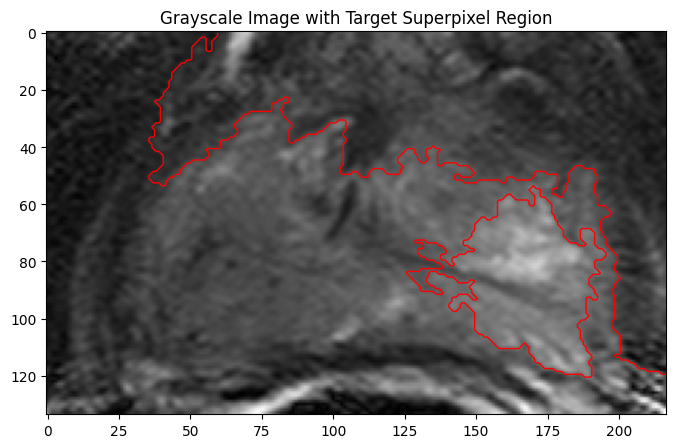

In [171]:
pa = r'G:\NKI dataset\Data_nifti\MRI002\NIFTIs\T2.nii'
img = nib.load(pa)
data_nifti = img.get_fdata()
image_slice = data_nifti[:, :, 9]
image_nifti = np.rot90(image_slice, 3)
image_nifti = np.fliplr(image_nifti)        
minni = np.min(image_nifti)
maxni = np.max(image_nifti)
rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
rescaled_image = rescaled_image.astype(np.uint8)
y_min = 199 - 25
y_max = 298 + 10
x_min = 193 - 20
x_max = 370 + 20
area = rescaled_image[y_min:y_max, x_min:x_max]
superpixel_labels = pixel_labels[19]

# 读取 Excel 文件
excel_path = r'C:\Users\alexg\Desktop\study\graduation project\code\unique_labels_726.xlsx'
excel_data = pd.read_excel(excel_path)

# 获取第35行中的 superpixel label
target_superpixel_label = excel_data.loc[0, 'Unique Labels']
target_superpixel_label = target_superpixel_label.strip('[]').split(', ')
print(target_superpixel_label)
# 初始化掩码
target_pixels_mask = np.zeros_like(superpixel_labels, dtype=bool)

# 挨个处理每个 superpixel label 并更新掩码
for label in target_superpixel_label:
    target_pixels_mask |= (superpixel_labels == int(label))

# target_pixels_mask = (superpixel_labels == int(target_superpixel_label.strip('[]')))

plt.figure(figsize=(8, 8))
plt.imshow(area, cmap='gray')
plt.contour(target_pixels_mask, colors='r', linewidths=1)  # 用红色标注目标区域
plt.title('Grayscale Image with Target Superpixel Region')
plt.show()

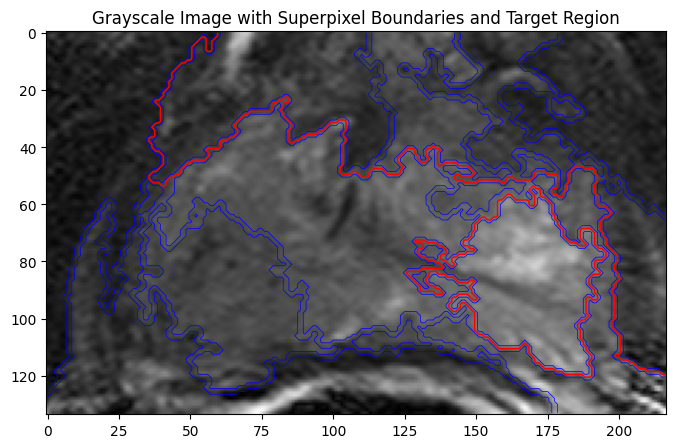

In [172]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

# 加载 NIfTI 文件
pa = r'G:\NKI dataset\Data_nifti\MRI002\NIFTIs\T2.nii'
img = nib.load(pa)
data_nifti = img.get_fdata()

# 处理切片
image_slice = data_nifti[:, :, 9]
image_nifti = np.rot90(image_slice, 3)
image_nifti = np.fliplr(image_nifti)
minni = np.min(image_nifti)
maxni = np.max(image_nifti)
rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
rescaled_image = rescaled_image.astype(np.uint8)

# 定义区域
y_min = 199 - 25
y_max = 298 + 10
x_min = 193 - 20
x_max = 370 + 20
area = rescaled_image[y_min:y_max, x_min:x_max]

# 假设 superpixel_labels 是预先定义好的，例如从某个处理流程中得到的
superpixel_labels = pixel_labels[19]

# 读取 Excel 文件
excel_path = r'C:\Users\alexg\Desktop\study\graduation project\code\unique_labels_726.xlsx'
excel_data = pd.read_excel(excel_path)

# 获取第35行中的 superpixel labels，并转换为整数列表
target_superpixel_label = excel_data.loc[0, 'Unique Labels']
target_superpixel_label = target_superpixel_label.strip('[]').split(', ')

# 初始化掩码
target_pixels_mask = np.zeros_like(superpixel_labels, dtype=bool)

# 挨个处理每个 superpixel label 并更新掩码
for label in target_superpixel_label:
    target_pixels_mask |= (superpixel_labels == int(label))

# 找到 superpixel 之间的边界
boundaries = find_boundaries(superpixel_labels, mode='inner')

plt.figure(figsize=(8, 8))
plt.imshow(area, cmap='gray')

# 绘制 superpixel 的边界
plt.contour(boundaries, colors='b', linewidths=0.5)  # 用蓝色标记 superpixel 边界

# 绘制选中区域的边界
plt.contour(target_pixels_mask, colors='r', linewidths=1)  # 用红色标记选中区域的边界

plt.title('Grayscale Image with Superpixel Boundaries and Target Region')
plt.show()


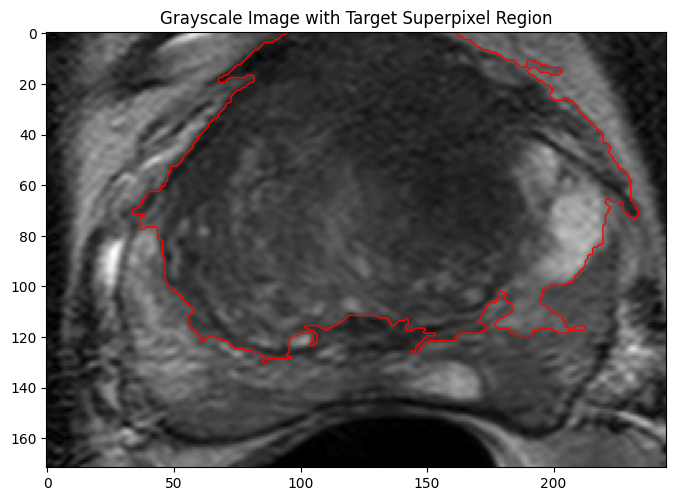

In [173]:
pa = r'G:\NKI dataset\Data_nifti\MRI006\NIFTIs\T2.nii'
img = nib.load(pa)
data_nifti = img.get_fdata()
image_slice = data_nifti[:, :, 11]
image_nifti = np.rot90(image_slice, 3)
image_nifti = np.fliplr(image_nifti)        
minni = np.min(image_nifti)
maxni = np.max(image_nifti)
rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
rescaled_image = rescaled_image.astype(np.uint8)
y_min = 139 - 25
y_max = 276 + 10
x_min = 137 - 20
x_max = 342 + 20
area = rescaled_image[y_min:y_max, x_min:x_max]
superpixel_labels = pixel_labels[31]

# 读取 Excel 文件
excel_path = r'C:\Users\alexg\Desktop\study\graduation project\code\unique_labels_726.xlsx'
excel_data = pd.read_excel(excel_path)

# 获取第35行中的 superpixel label
target_superpixel_label = excel_data.loc[1, 'Unique Labels']
target_superpixel_label = target_superpixel_label.strip('[]').split(', ')
# 初始化掩码
target_pixels_mask = np.zeros_like(superpixel_labels, dtype=bool)

# 挨个处理每个 superpixel label 并更新掩码
for label in target_superpixel_label:
    target_pixels_mask |= (superpixel_labels == int(label))

# target_pixels_mask = (superpixel_labels == int(target_superpixel_label.strip('[]')))

plt.figure(figsize=(8, 8))
plt.imshow(area, cmap='gray')
plt.contour(target_pixels_mask, colors='r', linewidths=1)  # 用红色标注目标区域
plt.title('Grayscale Image with Target Superpixel Region')
plt.show()

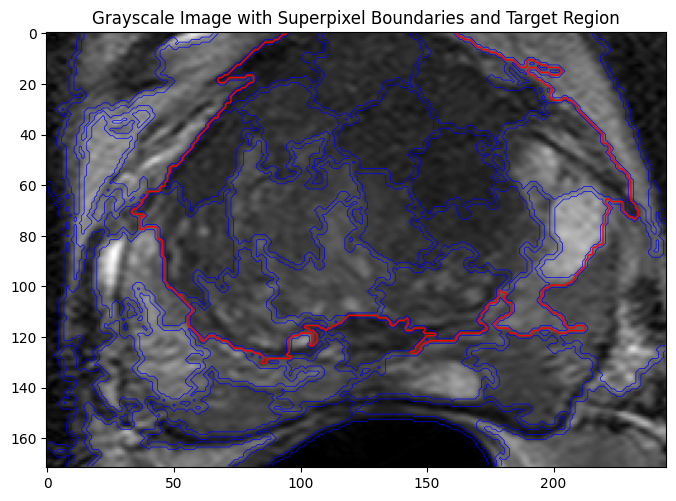

In [174]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

# 加载 NIfTI 文件
pa = r'G:\NKI dataset\Data_nifti\MRI006\NIFTIs\T2.nii'
img = nib.load(pa)
data_nifti = img.get_fdata()

# 处理切片
image_slice = data_nifti[:, :, 11]
image_nifti = np.rot90(image_slice, 3)
image_nifti = np.fliplr(image_nifti)
minni = np.min(image_nifti)
maxni = np.max(image_nifti)
rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
rescaled_image = rescaled_image.astype(np.uint8)

# 定义区域
y_min = 139 - 25
y_max = 276 + 10
x_min = 137 - 20
x_max = 342 + 20
area = rescaled_image[y_min:y_max, x_min:x_max]

# 假设 superpixel_labels 是预先定义好的，例如从某个处理流程中得到的
superpixel_labels = pixel_labels[31]

# 读取 Excel 文件
excel_path = r'C:\Users\alexg\Desktop\study\graduation project\code\unique_labels_726.xlsx'
excel_data = pd.read_excel(excel_path)

# 获取第35行中的 superpixel labels，并转换为整数列表
target_superpixel_label = excel_data.loc[1, 'Unique Labels']
target_superpixel_label = target_superpixel_label.strip('[]').split(', ')

# 初始化掩码
target_pixels_mask = np.zeros_like(superpixel_labels, dtype=bool)

# 挨个处理每个 superpixel label 并更新掩码
for label in target_superpixel_label:
    target_pixels_mask |= (superpixel_labels == int(label))

# 找到 superpixel 之间的边界
boundaries = find_boundaries(superpixel_labels, mode='inner')

plt.figure(figsize=(8, 8))
plt.imshow(area, cmap='gray')

# 绘制 superpixel 的边界
plt.contour(boundaries, colors='b', linewidths=0.5)  # 用蓝色标记 superpixel 边界

# 绘制选中区域的边界
plt.contour(target_pixels_mask, colors='r', linewidths=1)  # 用红色标记选中区域的边界

plt.title('Grayscale Image with Superpixel Boundaries and Target Region')
plt.show()


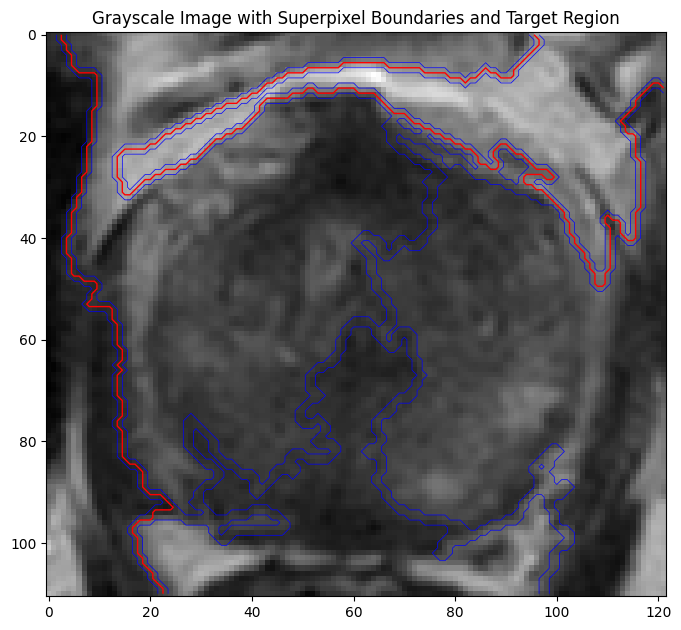

In [175]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

# 加载 NIfTI 文件
pa = r'G:\NKI dataset\Data_nifti\MRI056\NIFTIs\T2.nii'
img = nib.load(pa)
data_nifti = img.get_fdata()

# 处理切片
image_slice = data_nifti[:, :, 9]
image_nifti = np.rot90(image_slice, 3)
image_nifti = np.fliplr(image_nifti)
minni = np.min(image_nifti)
maxni = np.max(image_nifti)
rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
rescaled_image = rescaled_image.astype(np.uint8)

# 定义区域
y_min = 295 - 25
y_max = 371 + 10
x_min = 303 - 20
x_max = 385 + 20
area = rescaled_image[y_min:y_max, x_min:x_max]

# 假设 superpixel_labels 是预先定义好的，例如从某个处理流程中得到的
superpixel_labels = pixel_labels[691]

# 读取 Excel 文件
excel_path = r'C:\Users\alexg\Desktop\study\graduation project\code\unique_labels_726.xlsx'
excel_data = pd.read_excel(excel_path)

# 获取第35行中的 superpixel labels，并转换为整数列表
target_superpixel_label = excel_data.loc[34, 'Unique Labels']
target_superpixel_label = target_superpixel_label.strip('[]').split(', ')

# 初始化掩码
target_pixels_mask = np.zeros_like(superpixel_labels, dtype=bool)

# 挨个处理每个 superpixel label 并更新掩码
for label in target_superpixel_label:
    target_pixels_mask |= (superpixel_labels == int(label))

# 找到 superpixel 之间的边界
boundaries = find_boundaries(superpixel_labels, mode='inner')

plt.figure(figsize=(8, 8))
plt.imshow(area, cmap='gray')

# 绘制 superpixel 的边界
plt.contour(boundaries, colors='b', linewidths=0.5)  # 用蓝色标记 superpixel 边界

# 绘制选中区域的边界
plt.contour(target_pixels_mask, colors='r', linewidths=1)  # 用红色标记选中区域的边界

plt.title('Grayscale Image with Superpixel Boundaries and Target Region')
plt.show()


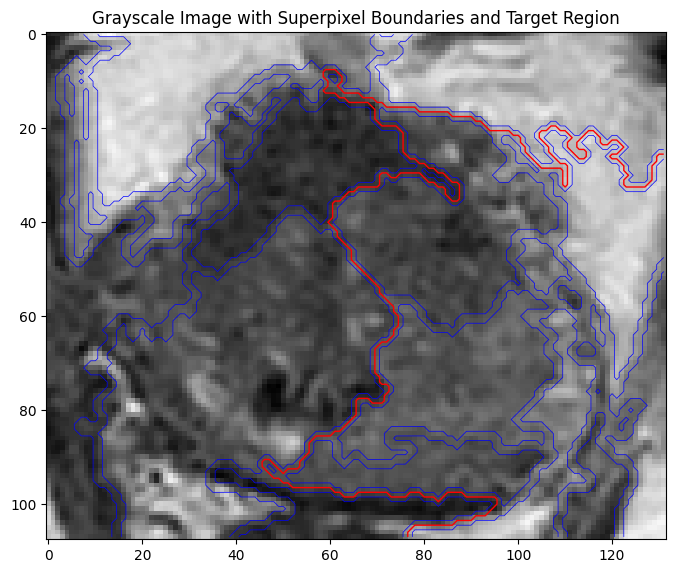

In [176]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries

# 加载 NIfTI 文件
pa = r'G:\NKI dataset\Data_nifti\MRI054\NIFTIs\T2.nii'
img = nib.load(pa)
data_nifti = img.get_fdata()

# 处理切片
image_slice = data_nifti[:, :, 8]
image_nifti = np.rot90(image_slice, 3)
image_nifti = np.fliplr(image_nifti)
minni = np.min(image_nifti)
maxni = np.max(image_nifti)
rescaled_image = ((image_nifti - minni) / (maxni - minni)) * 255
rescaled_image = rescaled_image.astype(np.uint8)

# 定义区域
y_min = 342 - 25
y_max = 415 + 10
x_min = 309 - 20
x_max = 401 + 20
area = rescaled_image[y_min:y_max, x_min:x_max]

# 假设 superpixel_labels 是预先定义好的，例如从某个处理流程中得到的
superpixel_labels = pixel_labels[665]

# 读取 Excel 文件
excel_path = r'C:\Users\alexg\Desktop\study\graduation project\code\unique_labels_726.xlsx'
excel_data = pd.read_excel(excel_path)

# 获取第35行中的 superpixel labels，并转换为整数列表
target_superpixel_label = excel_data.loc[33, 'Unique Labels']
target_superpixel_label = target_superpixel_label.strip('[]').split(', ')

# 初始化掩码
target_pixels_mask = np.zeros_like(superpixel_labels, dtype=bool)

# 挨个处理每个 superpixel label 并更新掩码
for label in target_superpixel_label:
    target_pixels_mask |= (superpixel_labels == int(label))

# 找到 superpixel 之间的边界
boundaries = find_boundaries(superpixel_labels, mode='inner')

plt.figure(figsize=(8, 8))
plt.imshow(area, cmap='gray')

# 绘制 superpixel 的边界
plt.contour(boundaries, colors='b', linewidths=0.5)  # 用蓝色标记 superpixel 边界

# 绘制选中区域的边界
plt.contour(target_pixels_mask, colors='r', linewidths=1)  # 用红色标记选中区域的边界

plt.title('Grayscale Image with Superpixel Boundaries and Target Region')
plt.show()


In [ ]:
# result = []
# tumor_proportions = []



# for index, row in column.iterrows():
#     alpha = row['Best Alpha Value']
#     image_index = int(round((alpha-5.0)/0.1))
#     coordinates = coordinates_all[index,:]
#     mask_tag = predicted_mask_all[20 * index + image_index]
#     superpixel_labels = pixel_labels[20 * index + image_index]
    
#     labels = []
#     tumor_mask = np.zeros(mask_tag.shape, dtype=bool)
#     for coord in coordinates[0]:
#         x, y = int(coord[0]), int(coord[1])
#         print(x)
#         print(y)
#         if 0 <= x <= mask_tag.shape[0] and 0 <= y <= mask_tag.shape[1]:
#             labels.append(superpixel_labels[x, y])
#             tumor_mask[x, y] = True
#         else:
#             print(f"Coordinate ({x}, {y}) is out of bounds for superpixel_labels with shape {superpixel_labels.shape}")
    
#     # 去除重复的label
#     unique_labels = list(set(labels))


    

#     # Calculate tumor proportion for each unique label
#     patient_tumor_proportions = []
#     total_tumor_area = len(coordinates[0])

#     for label in unique_labels:
#         superpixel_mask = (superpixel_labels == label)
#         print(len(superpixel_mask))
#         tumor_area_in_superpixel = np.sum(superpixel_mask & tumor_mask)
#         print(tumor_area_in_superpixel)
#         proportion = tumor_area_in_superpixel / total_tumor_area
#         print(proportion)
#         patient_tumor_proportions.append(proportion)
#         print(patient_tumor_proportions)
    
#     patient_tumor_proportions_all = list(patient_tumor_proportions)
    
#     tumor_proportions.append(patient_tumor_proportions_all)
#     # 保存结果
#     result.append(unique_labels)

# # 打印结果以验证
# # for idx, res in enumerate(result):
# #     print(f"Image {idx + 1}: {res}")

# # 创建一个 DataFrame，每行存储一个 unique_labels 列表
# df_f = pd.DataFrame({
#     'Image Index': range(1, 36),
#     'Unique Labels': result,
#     'Tumor Proportions': tumor_proportions
# })


# # 保存 DataFrame 到 Excel 文件
# df_f.to_excel('unique_labels_76.xlsx', index=False, engine='openpyxl')


In [19]:
# result = []
# tumor_proportions = []

# for index, row in column.iterrows():
#     alpha = row['Best Alpha Value']
#     image_index = int((alpha-5.0)/0.1)
#     coordinates = coordinates_all[index,:]
#     superpixel_labels = pixel_labels[20 * index + image_index]
    
#     labels = []
#     for coord in coordinates[0]:
#         x, y = int(coord[0]), int(coord[1])
#         if 0 <= x < superpixel_labels.shape[0] and 0 <= y < superpixel_labels.shape[1]:
#             labels.append(superpixel_labels[x, y])
#         else:
#             print(f"Coordinate ({x}, {y}) is out of bounds for superpixel_labels with shape {superpixel_labels.shape}")
    
#     # 去除重复的label
#     unique_labels = list(set(labels))
    
#     # 保存结果
#     result.append(unique_labels)

#     # Calculate tumor proportion for each unique label
#     patient_tumor_proportions = []
#     total_tumor_area = len(coordinates[0])

#     for label in unique_labels[index]:
#         superpixel_mask = (superpixel_labels == label)
#         tumor_area_in_superpixel = np.sum(superpixel_mask & (prostate_mask_all[20 * index + image_index] == 1))
#         proportion = tumor_area_in_superpixel / total_tumor_area
#         patient_tumor_proportions.append(proportion)
    
#     tumor_proportions.append(patient_tumor_proportions)

# # 打印结果以验证
# for idx, res in enumerate(result):
#     print(f"Image {idx + 1}: {res}")

# # 创建一个 DataFrame，每行存储一个 unique_labels 列表
# df_f = pd.DataFrame({
#     'Image Index': range(1, 36),
#     'Unique Labels': result
# })

# df_s = pd.DataFrame({
#     'Tumor Proportions': tumor_proportions
# })


# # 保存 DataFrame 到 Excel 文件
# df_f.to_excel('unique_labels.xlsx', index=False, engine='openpyxl')
# df_s.to_excel('unique_labels_with_proportions.xlsx', index=False, engine='openpyxl')


Image 1: [6, 7, 9, 10, 11]
Image 2: [6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 28, 30, 31, 32]
Image 3: [9, 11, 12, 16, 17, 22, 27]
Image 4: [64, 65, 73, 79, 82, 90, 93]
Image 5: [17, 21, 23, 24, 26, 27, 28, 30, 31, 33, 34, 36, 38, 39, 42, 44, 45, 47, 50, 51, 52, 54, 55, 57, 59, 63, 64]
Image 6: [4, 5, 6, 7]
Image 7: [32, 34, 40, 9, 11, 45, 46, 14, 17, 18, 21, 22, 25, 28]
Image 8: [9, 11, 13, 16, 17, 20, 23, 24, 26, 27, 29, 31]
Image 9: [10, 12]
Image 10: [11, 15, 22, 23, 25]
Image 11: [65, 66, 42, 46, 48, 50, 51, 52, 54, 55, 63]
Image 12: [32, 37, 44, 49, 24]
Image 13: [2, 9, 12, 13, 15, 16]
Image 14: [67, 69, 70, 76, 52, 60, 61]
Image 15: [10, 16, 20, 21, 22, 23, 28, 31, 35, 36, 37, 39, 43, 44, 45, 47, 49, 50, 52]
Image 16: [8, 1, 10, 2]
Image 17: [33, 39, 40, 41, 43, 47, 22, 23, 27, 28, 29]
Image 18: [5, 10, 11, 13, 15, 16, 17, 18, 26, 27, 30, 31]
Image 19: [8, 3, 4]
Image 20: [8, 9, 11]
Image 21: [1, 2, 6, 8, 9, 11, 12, 13, 14]
Image 22: [16, 13, 14, 15]


In [181]:
# 将 pixel_labels 转换为一个字典，每个数组作为一个键值对
mat_data = {f'image_{idx + 1}': labels for idx, labels in enumerate(pixel_labels)}

# 保存到 MAT 文件
scipy.io.savemat('all_labels.mat', mat_data)

print("Data saved to all_labels.mat successfully.")

Data saved to all_labels.mat successfully.
